# Low Pass Filter Comb Reverb

In [10]:
# Setup
from scipy.io import wavfile
import numpy as np
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy import signal
import sys
import requests
import io
from CircularBuffer import CircularBuffer, StereoDelay
from scipy.signal.windows import hann
from scipy.fft import fft, fftfreq, rfft, rfftfreq, ifft, irfft

# URL of the raw wave file on GitHub
# un-comment the URL of the file you want to use
# ATF Drums
github_url = "https://raw.githubusercontent.com/kevbrnen/Music-Technology-Final-Project/main/Sound%20Examples/Testing_Files/Around%20the%20fur%20drums.wav"
# KYW inst
#github_url = "https://raw.githubusercontent.com/kevbrnen/Music-Technology-Final-Project/main/Sound%20Examples/Testing_Files/KYW%20Inst.wav"

# Fetch the wave file from GitHub
response = requests.get(github_url)

# Check if the request was successful
if response.status_code == 200:
    # Read the wave data from the response content
    wave_data = io.BytesIO(response.content)
    
    # Read the wave file 
    fs, data = wavfile.read(wave_data)
    
else:
    print("Failed to fetch the wave file from GitHub")


# Get the bit depth of the audio data (assumes audio_data is a NumPy array)
bit_depth = data.dtype.itemsize * 8

# Calculate the scaling factor for normalization
scaling_factor = 2 ** (bit_depth - 1)  # For signed audio

# Convert audio data to floating-point values and normalize
data = data.astype(np.float32) / scaling_factor

# Verify that the data is now in the range -1 to 1
print(f"Min Value: {np.min(data)}")
print(f"Max Value: {np.max(data)}")

Min Value: -1.0
Max Value: 0.999969482421875


## Low-Pass Filter-Comb Reverberator
Comb Filter Reverb with low pass filter in feedback loop to replicate how high frequencies act in a real room 

In [11]:
# Setting up IIR Lowpass filter
fc = 9000
b, a = signal.iirfilter(3, fc, btype='lowpass', ftype='butter', output='ba', fs=fs)

w, H = signal.freqz(b, a)

/var/folders/wl/6gyc0yz53snb8mbsbvf6rnh80000gn/T/ipykernel_90244/1108149781.py:12: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, fs/2])  # Set x-axis limits
/var/folders/wl/6gyc0yz53snb8mbsbvf6rnh80000gn/T/ipykernel_90244/1108149781.py:24: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, fs/2])  # Set x-axis limits


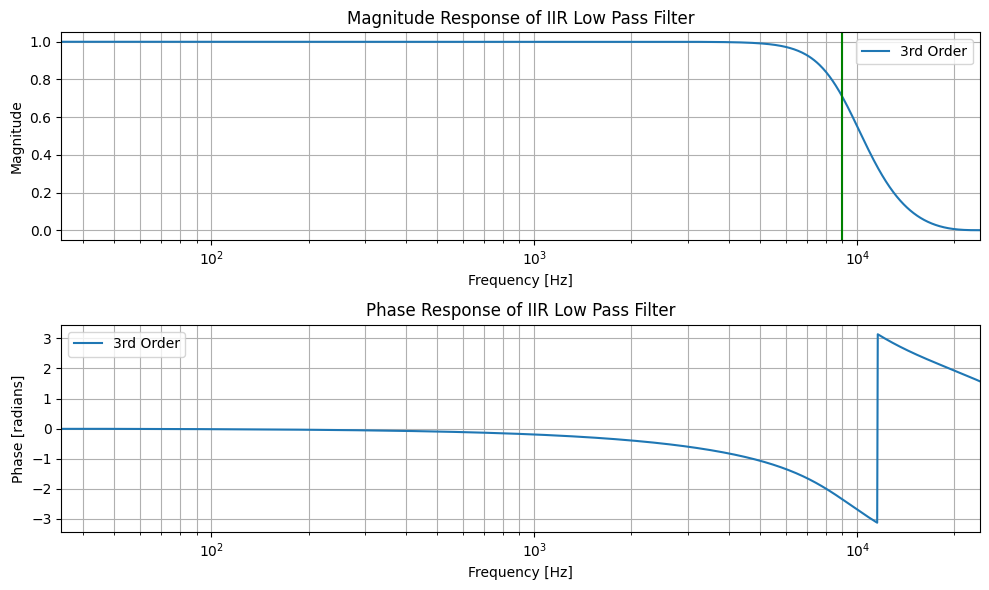

In [12]:
freq_hz = w * (fs / (2 * np.pi))

# Plot magnitude and phase responses in Hz
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(freq_hz, np.abs(H), label='3rd Order')
plt.title('Magnitude Response of IIR Low Pass Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid(which='both')
plt.xscale('log')  # Set x-axis to a logarithmic scale
plt.xlim([0, fs/2])  # Set x-axis limits
plt.axvline(fc, color='green')
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(freq_hz, np.angle(H), label='3rd Order')
plt.title('Phase Response of IIR Low Pass Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [radians]')
plt.grid(which='both')
plt.xscale('log')  # Set x-axis to a logarithmic scale
plt.xlim([0, fs/2])  # Set x-axis limits
plt.legend()


plt.tight_layout()
plt.show()

In [17]:
# Wet Dry
DryAmt = 0.4

delay_amt = 0.071 #in seconds
delay_amt_samples = delay_amt * fs

delayLine = StereoDelay(delay_amt_samples, delay_amt_samples)

g = 0.75

output = np.zeros(((int)(len(data)/2), 2))

for i in range((int)(len(data)/2)):
    delayed = delayLine.get_samples_from_buffer()

    output[i] = np.multiply((1 - DryAmt) , delayed) + np.multiply(DryAmt, data[i + (int)(len(data)/2)])

    delayed = signal.lfilter(b, a, delayed)

    delayed = np.multiply(delayed, g)

    delayLine.push_samples_to_buffer(delayed + data[i + (int)(len(data)/2)])


#Normalisation
max_amplitude = np.max(np.abs(output))
normalized_audio = output / max_amplitude

In [18]:
sd.play(normalized_audio,fs)

In [19]:
#sf.write("08-Lowpass_Comb_Filter_Reverb_Example.wav", normalized_audio, fs)

# Impulse Response of System

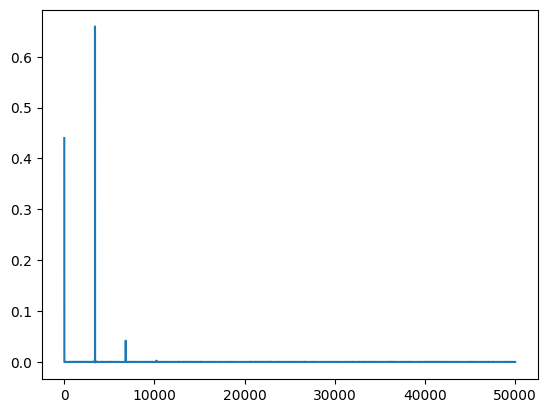

In [ ]:
# Apply windowing
window = hann(len(data))
original_signal = data[:,0] * window
filtered_signal = normalized_audio[:,0] * window

original_spectrum = fft(original_signal)
filtered_spectrum = fft(filtered_signal)

epsilon = 1e-10

impulse_response_spectrum = filtered_spectrum/(original_spectrum + epsilon)

impulse_response = np.real(ifft(impulse_response_spectrum))

plt.plot(impulse_response[0:50000])

In [ ]:
sd.play(output, fs)

In [ ]:
sd.play(data, fs)